# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [20]:
#Load DB
import sqlite3 as sql
connection = sql.connect("sf_data.sqlite")
cursor = connection.cursor()

In [21]:
cursor.execute("PRAGMA table_info(mobile_food_locations);")
cursor.fetchall()

[(0, u'locationid', u'INTEGER', 0, None, 0),
 (1, u'LocationDescription', u'TEXT', 0, None, 0),
 (2, u'Address', u'TEXT', 0, None, 0),
 (3, u'Latitude', u'REAL', 0, None, 0),
 (4, u'Longitude', u'REAL', 0, None, 0)]

In [22]:
cursor.execute("PRAGMA table_info(mobile_food_permits);")
cursor.fetchall()

[(0, u'permit', u'TEXT', 0, None, 0),
 (1, u'Status', u'TEXT', 0, None, 0),
 (2, u'Applicant', u'TEXT', 0, None, 0),
 (3, u'FacilityType', u'TEXT', 0, None, 0),
 (4, u'FoodItems', u'TEXT', 0, None, 0),
 (5, u'PriorPermit', u'INTEGER', 0, None, 0),
 (6, u'Approved', u'TIMESTAMP', 0, None, 0),
 (7, u'Expiration', u'TIMESTAMP', 0, None, 0)]

In [23]:
cursor.execute("PRAGMA table_info(mobile_food_schedule);")
cursor.fetchall()

[(0, u'locationid', u'INTEGER', 0, None, 0),
 (1, u'permit', u'TEXT', 0, None, 0),
 (2, u'DayOfWeek', u'TEXT', 0, None, 0),
 (3, u'EndHour', u'INTEGER', 0, None, 0),
 (4, u'StartHour', u'INTEGER', 0, None, 0)]

In [24]:
cmd = """
SELECT permit, locationCount
FROM (SELECT permit, COUNT(locationid) as locationCount FROM mobile_food_schedule GROUP BY permit)
ORDER BY locationCount DESC LIMIT 5
"""
cursor.execute(cmd)
result = cursor.fetchall()
import pandas as pd
#Top 5 mobile vendors ranked by number of locations sold. 
top5Vendors = pd.DataFrame(result, columns=["permitID", "Location Count"])
top5Vendors

,permitID,Location Count
0,17MFF-0110,340
1,13MFF-0102,221
2,17MFF-0111,212
3,17MFF-0090,182
4,14MFF-0109,165


In [25]:
cmd = "SELECT permit, Applicant FROM mobile_food_permits WHERE permit in ('"+"','".join(top5Vendors["permitID"].astype(str))+"')"
pd.read_sql_query(cmd, connection)

,permit,Applicant
0,13MFF-0102,Natan's Catering
1,14MFF-0109,Mang Hang Catering
2,17MFF-0110,May Catering
3,17MFF-0111,Anas Goodies Catering
4,17MFF-0090,Liang Bai Ping


__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [28]:
%matplotlib inline
# Make plots larger.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go

#### 1. Analysis of Crime in SF 
Question: Which part of SF has the most crime? What day of the week has the most crime? What type of crime happen most often.

In [29]:
#Crime table columns
cursor.execute("PRAGMA table_info(crime);")
cursor.fetchall()

[(0, u'IncidntNum', u'INTEGER', 0, None, 0),
 (1, u'Category', u'TEXT', 0, None, 0),
 (2, u'Descript', u'TEXT', 0, None, 0),
 (3, u'DayOfWeek', u'TEXT', 0, None, 0),
 (4, u'Datetime', u'TIMESTAMP', 0, None, 0),
 (5, u'PdDistrict', u'TEXT', 0, None, 0),
 (6, u'Resolution', u'TEXT', 0, None, 0),
 (7, u'Address', u'TEXT', 0, None, 0),
 (8, u'Lon', u'REAL', 0, None, 0),
 (9, u'Lat', u'REAL', 0, None, 0)]

In [34]:
cursor.execute("PRAGMA table_info(crime);")
cursor.fetchall()
#Find day of week with most crime
cursor.execute("SELECT COUNT(IncidntNum), DayOfWeek FROM crime GROUP BY DayOfWeek ORDER BY COUNT(IncidntNum) DESC")
df1 = pd.DataFrame(cursor.fetchall(), columns = ["Count", "DayOfWeek"])
#Find police district with most crime
cursor.execute("SELECT COUNT(IncidntNum), Category FROM crime GROUP BY Category ORDER BY COUNT(IncidntNum) DESC LIMIT 20")
df2 = pd.DataFrame(cursor.fetchall(), columns= ["Count", "Category"])

In [35]:
trace1 = go.Bar(
    x=df1.DayOfWeek,
    y=df1.Count,
    name='DayOfWeek'
)
data = [trace1]
layout = go.Layout(
    barmode='group',
    xaxis=dict(
        title='DayOfWeek',
        type='category',
        autorange=True
    ),
    yaxis=dict(title='Count of Crime by Day')
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [36]:
trace1 = go.Bar(
    x=df2.Category,
    y=df2.Count,
    name='Category'
)
data = [trace1]
layout = go.Layout(
    barmode='group',
    xaxis=dict(
        title='Category',
        type='category',
        autorange=True
    ),
    yaxis=dict(title='Count of Crime by Category')
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [39]:
crime = pd.read_sql_query("SELECT * FROM crime", connection)

In [40]:
import shapely.geometry as geom
import geopandas as gpd
lonlat = [geom.Point(lon, lat) for lon, lat in zip(crime.Lon, crime.Lat)]
#crime.drop(["Lon", "Lat"], axis = 1)

In [41]:
crime = gpd.GeoDataFrame(crime, geometry = lonlat, crs = {'init' :'epsg:4326'})
from datetime import datetime
crime.Datetime = pd.to_datetime(crime.Datetime)
crime2014_2015 = crime[crime.Datetime.dt.year > 2013] 

In [44]:
SFshape = gpd.read_file('./SF Find Neighborhoods/geo_export_3b3593e2-9599-405f-80d4-bfe4d713cdc1.shp')

In [45]:
crime2014_2015= crime2014_2015.to_crs(SFshape.crs)

In [46]:
df3=pd.read_sql_query("SELECT COUNT(IncidntNum) AS Count, PdDistrict FROM crime GROUP BY PdDistrict ORDER BY COUNT(IncidntNum)", connection)
trace1 = go.Bar(
    x=df3.loc[1:,].PdDistrict,
    y=df3.Count,
    name='PdDistrict'
)
data = [trace1]
layout = go.Layout(
    barmode='group',
    xaxis=dict(
        title='Police District',
        type='category',
        autorange=True
    ),
    yaxis=dict(title='Count of Crime by Police District')
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

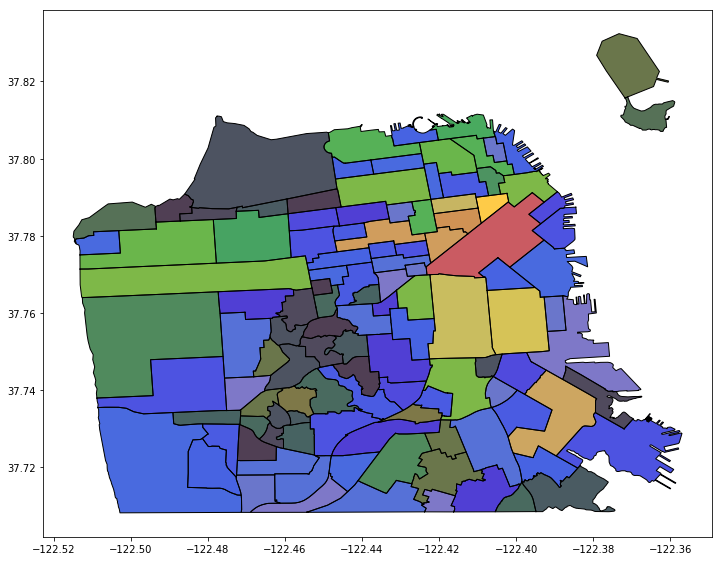

In [102]:
from geopandas.plotting import plot_multipolygon
base = SFshape.plot()
for index, shape in SFshape.iterrows():
    tmp = crime2014_2015[crime2014_2015.geometry.within(shape.geometry)]
    if len(tmp) <= 1000:
        plot_multipolygon(base, shape.geometry, facecolor="black", edgecolor='none')
    elif 1000 < len(tmp) <= 5000:
        plot_multipolygon(base, shape.geometry, facecolor="blue", edgecolor='none')
    elif 5000 < len(tmp) <= 10000:
        plot_multipolygon(base, shape.geometry, facecolor="green", edgecolor='none')
    elif 10000 < len(tmp) <= 50000:
        plot_multipolygon(base, shape.geometry, facecolor="orange", edgecolor='none')
    else:
        plot_multipolygon(base, shape.geometry, facecolor="red", edgecolor='none')

Based on the above plots, we can say that crime tends to be high towards the weekends (Friday and Saturday). The majority of the crime reported is larceny/theft followed by other offenses and non-criminal. From the distribution of crime across police district, we see that the southern, mission, and norther police districts have the most crime over all time. This sort of correspond with what we see in the neighborhood map, with the more orange, redish colors identifying the locations with high crime rate for years 2014 and 2015. 

#### 2. Analysis of SF housing price 
Question: Locate the most expensive and cheapest living areas in SF and examine how public resources (parks, schools, and parking lots) are allocated. 

In [48]:
zips = gpd.read_file("./cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")
# According to Wikipedia, SAN FRANCISCO zips are 94100 - 94200
zips = zips[zips.ZCTA5CE10.str.startswith("9")]
zips = zips[pd.to_numeric(zips.ZCTA5CE10).between(94100,94200)]

In [49]:
zillow = pd.read_sql_query("SELECT * FROM zillow",connection)

In [50]:
zillowPriceByZip = zillow[["RegionName","MedianSoldPricePerSqft_AllHomes","PriceToRentRatio_AllHomes"]].groupby("RegionName").mean()

In [51]:
trace1 = go.Bar(
    x=zillowPriceByZip.index,
    y=zillowPriceByZip.MedianSoldPricePerSqft_AllHomes,
    name='MedianSoldPricePerSqft_AllHomes'
)
trace2 = go.Bar(
    x=zillowPriceByZip.index,
    y=zillowPriceByZip.PriceToRentRatio_AllHomes,
    name='PriceToRentRatio_AllHomes'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    xaxis=dict(
        title='Zip Code',
        type='category',
        autorange=True
    ),
    yaxis=dict(title='Average for Zip')
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Highest median sold price per sqft zipcode is 94104, while highest price to rent ratio is 94123. 
Lowest median sold price per sqft and  price to rent ratio  zipcode is 94124.
There is no rent information for 94104 and 94118, which is interesting. 

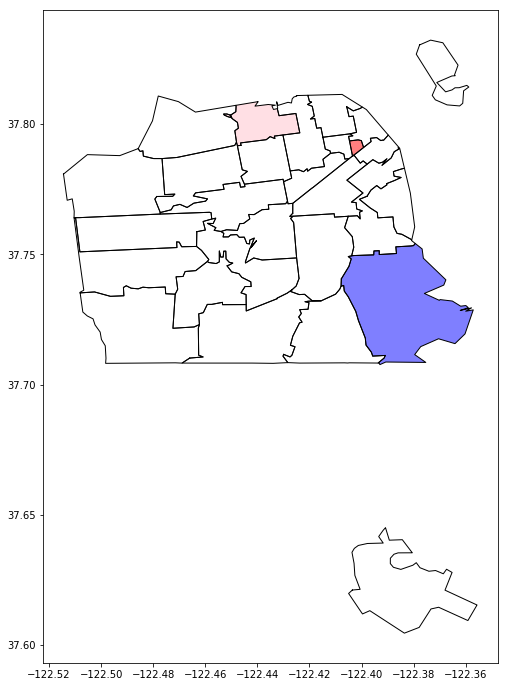

In [251]:
base = zips.plot(color = "white")
plot_multipolygon(base, zips[pd.to_numeric(zips.ZCTA5CE10).isin([94104])].geometry.iloc[0], \
                  facecolor="red", edgecolor='none')
plot_multipolygon(base, zips[pd.to_numeric(zips.ZCTA5CE10).isin([94123])].geometry.iloc[0], \
                  facecolor="pink", edgecolor='none')
plot_multipolygon(base, zips[pd.to_numeric(zips.ZCTA5CE10).isin([94124])].geometry.iloc[0], \
                  facecolor="blue", edgecolor='none')


In [255]:
goalZip = [94104, 94123, 94124]
parking = pd.read_sql_query("SELECT * FROM parking",connection)
parks = pd.read_sql_query("SELECT * FROM parks",connection)
school = pd.read_sql_query("SELECT * FROM schools", connection)

In [343]:
def getGeom(data):
    lonlat = [geom.Point(lon, lat) for lon, lat in zip(data.Lon, data.Lat)]
    return(gpd.GeoDataFrame(data, geometry = lonlat, crs = {'init' :'epsg:4326'}))

sf_parking = getGeom(parking)
sf_parks = getGeom(parks)
sf_school = getGeom(school)

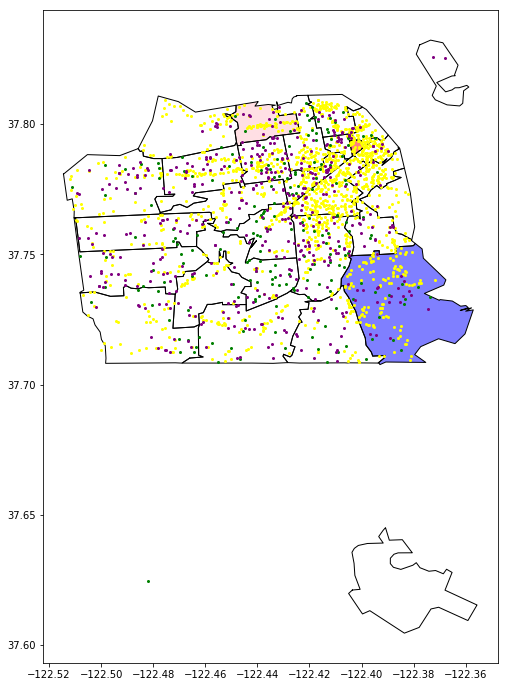

In [344]:
base = zips.plot(color = "white")
plot_multipolygon(base, zips[pd.to_numeric(zips.ZCTA5CE10).isin([94104])].geometry.iloc[0], \
                  facecolor="red", edgecolor='none')
plot_multipolygon(base, zips[pd.to_numeric(zips.ZCTA5CE10).isin([94123])].geometry.iloc[0], \
                  facecolor="pink", edgecolor='none')
plot_multipolygon(base, zips[pd.to_numeric(zips.ZCTA5CE10).isin([94124])].geometry.iloc[0], \
                  facecolor="blue", edgecolor='none')
sf_parking.plot(ax = base, marker = "o", color = "yellow")
#Dropped outlying park point
sf_parks = sf_parks.drop(33)
sf_parks.plot(ax = base, marker = "o", color = "green")
sf_school.plot(ax = base, marker = "o", color = "purple")


Base off this map illustrating resource allocations of the city, it makes sense for 94104 to be the most expensive living space in SF, considering how it is hub of activity. Also it makes sense for 94123 to be cheaper since it is further away from the main city and closer to Southern SF. 94123 may have higher rent due ot its proximity to the presidio.

#### Parking in SF
SF is notorious for difficulty in parking. So I want to know all the free public parking or paid parking locations are. 

In [587]:
parkingTypes = pd.read_sql_query("SELECT PrimeType, COUNT(PrimeType) as Count FROM parking GROUP BY PrimeType",connection)

In [588]:
trace1 = go.Bar(
    x=parkingTypes['PrimeType'],
    y=parkingTypes['Count'],
    name="Parking Types"
)
data = [trace1]
layout = go.Layout(
    barmode='group',
    xaxis=dict(
        type='category',
        autorange=True
    ),
    yaxis=dict(title='Count')
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

According to SF open data, these are what the acronyms stand for. 
Parking categories: paid, publicly available (PPA): drive up and pay, typically by the hour or by the day; customer parking only (CPO): typically for businesses or religious institutions; permit holder only (PHO, CGO): i.e. employees only, students only, monthly only; free publicly available (FPA): free off-street parking.

Based off the above plot, we see that there is very little free public parking in SF. Let's plot the information on a map to see where we can find the FPA. 

In [615]:
types = parkingTypes["PrimeType"][1:].values
types

array([u'CGO', u'CPO', u'FPA', u'PHO', u'PPA'], dtype=object)

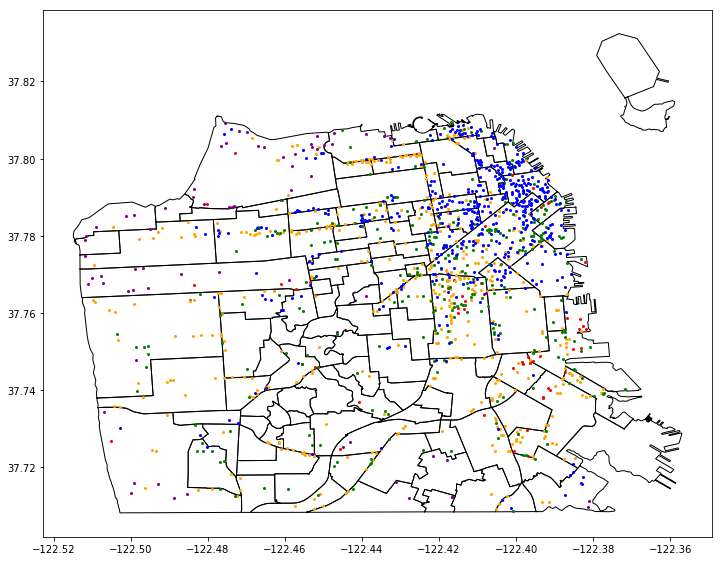

In [620]:
base = SFshape.plot(color = "white")
color = ['red','orange','purple','green','blue']
for i in range(0,5):
    tmpdata = sf_parking[sf_parking.PrimeType == types[i]]
    tmpdata.plot(ax = base, marker = "o", color = color[i])

The color code for the parking types are:

- CGO - Red
- CPO - Orange
- FPA - Purple
- PHO - Green
- PPA - Blue

We can see that there is a lot of paid public parking in east side of SF, while customer parking is sparsely distributed all over SF. Free public parking, to which we are interested in, is primarily available by the norther edge of SF, near golden gate bridge. 

#### 4. Noise Level and Crime
Quantitate the relationship between crime and noise level.

In [386]:
noise = pd.read_sql_query("SELECT * FROM noise",connection)
sf_noise = getGeom(noise)
crime2015 = crime[crime.Datetime.dt.year > 2014] 

In [487]:
NeighborhoodCrime = list()
for index, shape in SFshape.iterrows():
    crimeNo = len(crime2015[crime2015.geometry.within(shape.geometry)])
    noiseNo = len(sf_noise[sf_noise.geometry.within(shape.geometry)])
    NeighborhoodCrime.append({'Neighborhood': shape['name'], 'crimeNo': crimeNo, 'noiseNo': noiseNo})

In [488]:
data = pd.DataFrame(NeighborhoodCrime)
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data[["crimeNo","noiseNo"]])
df_normalized = pd.DataFrame(np_scaled)

In [489]:
data['crimeNo'] = df_normalized[0]
data['noiseNo'] = df_normalized[1]
data['crimeNo'].corr(data['noiseNo'])

0.87346615156353991

In [490]:
trace1 = go.Bar(
    x=data.Neighborhood,
    y=data.crimeNo,
    name="Crime Number"
)
trace2 = go.Bar(
    x=data.Neighborhood,
    y=data.noiseNo,
    name="Noise Number"
)

data1 = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    xaxis=dict(
        type='category',
        autorange=True
    ),
    yaxis=dict(title='Scaled Number')
)
fig = go.Figure(data=data1, layout=layout)
py.iplot(fig)

In [495]:
trace = go.Scatter(
    x = data['crimeNo'],
    y = data['noiseNo'],
    mode = 'markers'
)

data2 = [trace]
layout = go.Layout(
    xaxis=dict(title='Scaled Crime'),
    yaxis=dict(title='Scaled Noise')
)
fig = go.Figure(data=data2,layout=layout)
py.iplot(fig)

Using a scaled version of the count, we can see that noise level follows an approximate pattern as crime level. Although sometimes high noise level may not indicate high crime and vice versa, from the scatter plot and pearson correlation, we see that crime and noise is highly correlated.

#### 5. Food Trucks
When and where do most food trucks operate, in other words, what are the best times and places to find food trucks?

In [523]:
ftlocation = pd.read_sql_query("SELECT * FROM mobile_food_locations WHERE Latitude IS NOT 0 AND Longitude IS NOT 0", connection)
lonlat = [geom.Point(lon, lat) for lon, lat in zip(ftlocation.Longitude, ftlocation.Latitude)]
sf_ftlocation = gpd.GeoDataFrame(ftlocation, geometry = lonlat, crs = {'init' :'epsg:4326'})

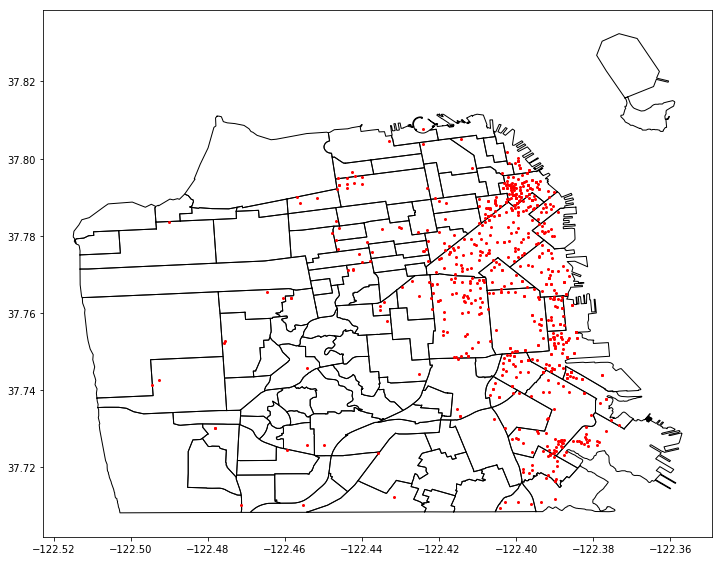

In [525]:
base = SFshape.plot(color = "white")
sf_ftlocation.plot(ax = base, marker = "o", color = "red")

In [557]:
ftschedule_Day = pd.read_sql_query("SELECT DayOfWeek, COUNT(DISTINCT(locationid)) as Count FROM mobile_food_schedule GROUP BY DayOfWeek", connection)
ftschedule_Start = pd.read_sql_query("SELECT StartHour, COUNT(DISTINCT(locationid))  as Count FROM mobile_food_schedule GROUP BY StartHour", connection)
ftschedule_End = pd.read_sql_query("SELECT EndHour, COUNT(Distinct(locationid)) as Count FROM mobile_food_schedule GROUP BY EndHour", connection)

In [558]:
from plotly import tools

trace1 = go.Bar(x=ftschedule_Day['DayOfWeek'], y = ftschedule_Day['Count'], name = "DayOfWeek")
trace2 = go.Bar(x=ftschedule_Start['StartHour'], y=ftschedule_Start['Count'], name = "StartHour")
trace3 = go.Bar(x=ftschedule_End['EndHour'], y=ftschedule_End['Count'], name = "EndHour")
fig = tools.make_subplots(rows=3, cols=1, subplot_titles=('DayOfWeek', 'StartHour','EndHour'))

fig.append_trace(trace1, 1, 1, )
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)

fig['layout'].update(height=600, width=600, title= "Histogram of Food Truck Day and Hours")

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



Based on the location plot and the hour and day distribution of food trucks, I find it suprising to see less foodtrucks operate on weekends on than weekdays. Foodtrucks seem to run a regular operation schedule. Most of them start at 10AM and clsoe in the afternoon or after lunch times. Given that most foodtruck operate in the financial district, south of market area and during weekdays, the primary customers seem to be urban workers. Possibly serving during lunch hours. 